In [502]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [527]:
data = pd.read_csv('cloakroom.csv')
data.shape

(76, 8)

In [504]:
data.head(5)

,#,Ticket,Color,Date,Day_Of_Week,Time,Jeans,Section
0,1,1015,blue,23.09.24,Monday,11:09,black,2
1,2,1175,black,23.09.24,Monday,15:35,black,2
2,3,1068,blue,26.09.24,Thursday,12:52,blue,2
3,4,919,blue,27.09.24,Friday,11:02,black,2
4,5,958,black,27.09.24,Friday,17:53,black,2


In [505]:
data.isna().sum()

#              0
Ticket         0
Color          0
Date           0
Day_Of_Week    0
Time           0
Jeans          7
Section        0
dtype: int64

In [528]:
data = data.drop('#', axis=1)
data = data.fillna("")
data.isna().sum()

Ticket         0
Color          0
Date           0
Day_Of_Week    0
Time           0
Jeans          0
Section        0
dtype: int64

In [529]:
def time_encoding(times):
    time_in_minutes = []
    for time in times:
        hour, minutes = map(int, time.split(':'))
        time_in_minutes.append(hour * 60 + minutes)
    return np.array(time_in_minutes)

In [508]:
def date_encoding(dates):
    days, months = [], []
    for date in dates:
        day, month, year = map(int, date.split('.'))

        month_in_year = 12
        days_in_month = 30
        if month in [1, 3, 5, 7, 8, 10, 12]:
            days_in_month = 31
        if month == 2:
            year += 2000
            if year % 4 == 0 and year % 100 != 0 or year % 400 == 0:
                days_in_month = 29
            else: 
                days_in_month = 28

        new_day = np.sin(2 * np.pi * day / days_in_month)
        new_month = np.sin(2 * np.pi * month / month_in_year)

        days.append(new_day)
        months.append(new_month)
    
    return np.array(days), np.array(months)

In [509]:
def day_of_week_encoding(days_of_week):
    days = []
    days_in_week = 7
    for day in days_of_week:
        number = 0
        match day:
            case 'Monday': number = 1
            case 'Tuesday': number = 2
            case 'Wednesday': number = 3
            case 'Thursday': number = 4
            case 'Friday': number = 5
            case 'Saturday': number = 6
            case 'Sunday': number = 7

        day_sin = np.cos(2 * np.pi * number / days_in_week)
        days.append(day_sin)
    return np.array(days)


In [530]:
data['Time_Minutes'] = time_encoding(data['Time'])
data = data.drop('Time', axis=1)

days, months = date_encoding(data['Date'])
data['Day_sin'] = days
data['Month_sin'] = months
data = data.drop('Date', axis=1)

data['Day_Of_Week_sin'] = day_of_week_encoding(data['Day_Of_Week'])
data = data.drop('Day_Of_Week', axis=1)

data = pd.get_dummies(data, drop_first=True)

data.head()

,Ticket,Section,Time_Minutes,Day_sin,Month_sin,Day_Of_Week_sin,Color_blue,Jeans_black,Jeans_blue
0,1015,2,669,-0.994522,-1.0,0.623490,True,True,False
1,1175,2,935,-0.994522,-1.0,0.623490,False,True,False
2,1068,2,772,-0.743145,-1.0,-0.900969,True,False,True
3,919,2,662,-0.587785,-1.0,-0.222521,True,True,False
4,958,2,1073,-0.587785,-1.0,-0.222521,False,True,False


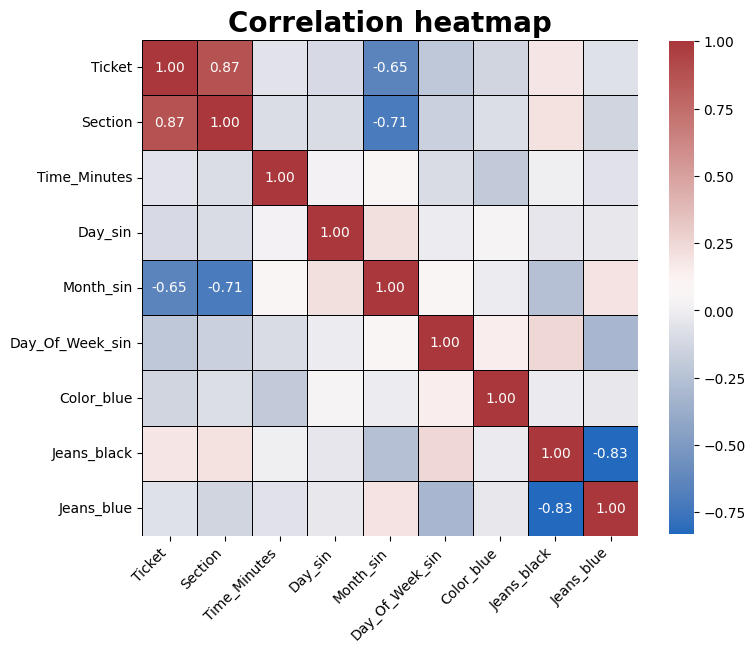

In [531]:
plt.figure(figsize=(8, 8), dpi=100)

ax = sns.heatmap(
    data.corr(numeric_only=True),
    cmap='vlag',
    annot=True,
    fmt='0.2f',
    linewidths=0.5,
    linecolor='black',
    cbar_kws={'shrink': 0.8},
    square=True
)

for t in ax.texts:
    if np.abs(float(t.get_text())) < 0.5:
        t.set_text("")

plt.title('Correlation heatmap', fontsize=20, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.show()

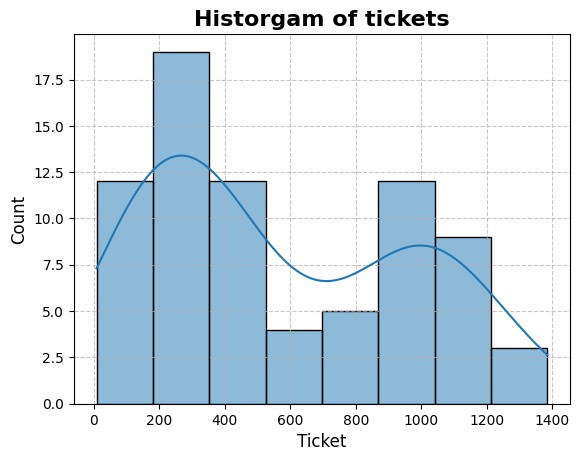

In [532]:
plt.figure(dpi=100)
sns.histplot(data["Ticket"], kde=True)
plt.title('Historgam of tickets', fontsize=16, fontweight='bold')
plt.xlabel('Ticket', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [533]:
X = data.drop('Ticket', axis=1)
y = data['Ticket']

In [534]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV

In [535]:
np.random.seed(8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

In [536]:
def MAPE(y: np.array, y_pred: np.array):
    return (np.abs((y - y_pred) / y)).mean() * 100

In [537]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_train_predict = linreg.predict(X_train)
y_test_predics = linreg.predict(X_test)

print(f"MAPE for train: {MAPE(y_train, y_train_predict):.2f}")
print(f"MAPE for test: {MAPE(y_test, y_test_predics):.2f}")

MAPE for train: 88.25
MAPE for test: 327.58


In [539]:
df_features = pd.DataFrame({
    'Feature': linreg.feature_names_in_,
    'Coefficient': linreg.coef_,
    'Coefficient (abs)': np.abs(linreg.coef_)
})
df_features.sort_values(by='Coefficient (abs)', inplace=True, ascending=False)
df_features

,Feature,Coefficient,Coefficient (abs)
0,Section,559.377329,559.377329
7,Jeans_blue,141.034118,141.034118
3,Month_sin,-106.307646,106.307646
5,Color_blue,-71.468569,71.468569
6,Jeans_black,68.267924,68.267924
4,Day_Of_Week_sin,-52.148954,52.148954
2,Day_sin,3.268329,3.268329
1,Time_Minutes,-0.040436,0.040436


In [540]:
alphas = []
lasso_coef_norms = []
ridge_coef_norms = []

for alpha in np.arange(0.1, 250, 0.1):
    alphas.append(alpha)
    lasso = Lasso(alpha).fit(X_train, y_train)
    ridge = Ridge(alpha).fit(X_train, y_train)

    lasso_coef_norms.append(np.linalg.norm(lasso.coef_))
    ridge_coef_norms.append(np.linalg.norm(ridge.coef_))

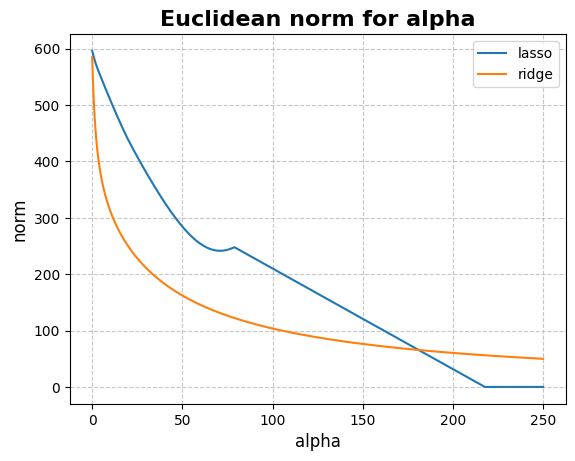

In [541]:
fig = plt.figure(dpi=100)
plt.plot(alphas, lasso_coef_norms, label='lasso')
plt.plot(alphas, ridge_coef_norms, label='ridge')
plt.xlabel('alpha', fontsize=12)
plt.ylabel('norm', fontsize=12)
plt.legend()
plt.title("Euclidean norm for alpha", fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [542]:
lasso_cv = LassoCV(alphas=np.arange(0.1, 250, 0.1), cv=5, random_state=8, max_iter=5000).fit(X_train, y_train)

best_alpha_lasso = lasso_cv.alpha_

print(f"Наилучшее качество Lasso при alpha = {best_alpha_lasso:.2f}.")

lasso = Lasso(alpha=best_alpha_lasso).fit(X_train, y_train)
ridge = Ridge(alpha=best_alpha_lasso).fit(X_train, y_train)

Наилучшее качество Lasso при alpha = 7.40.


In [543]:
ridge_cv = RidgeCV(alphas=np.arange(0.1, 300, 0.1), store_cv_results=True).fit(X_train, y_train)

best_alpha_ridge = ridge_cv.alpha_

print(f"Наилучшее качество Ridge при alpha = {best_alpha_ridge:.2f}.")

ridge = Ridge(alpha=best_alpha_ridge).fit(X_train, y_train)

Наилучшее качество Ridge при alpha = 0.10.


In [544]:
mape_ridge = MAPE(y_test, ridge.predict(X_test))
mape_lasso = MAPE(y_test,  lasso.predict(X_test))
mape_linreg = MAPE(y_test, linreg.predict(X_test))

print(f"MAPE Ridge: {mape_ridge:.2f}")
print(f"MAPE Lasso: {mape_lasso:.2f}")
print(f"MAPE Linreg: {mape_linreg:.2f}")

MAPE Ridge: 328.80
MAPE Lasso: 318.21
MAPE Linreg: 327.58


In [547]:
from sklearn.neighbors import KNeighborsClassifier

k_best = 0
mape_knn = 10**100
for k in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    pred_knn = knn.predict(X_test)

    mape_knn_for_k = MAPE(y_test, pred_knn)

    if mape_knn_for_k < mape_knn:
        k_best = k
        mape_knn = mape_knn_for_k

knn = KNeighborsClassifier(n_neighbors=k_best)
print(f"Точность KNN: {mape_knn:.2f} при k = {k_best}.")

Точность KNN: 94.84 при k = 7.


In [548]:
new_data = pd.read_csv('test.csv')
X_new = new_data

X_new['Time_Minutes'] = time_encoding(X_new['Time'])
X_new = X_new.drop('Time', axis=1)

days, months = date_encoding(X_new['Date'])
X_new['Day_sin'] = days
X_new['Month_sin'] = months
X_new = X_new.drop('Date', axis=1)

X_new['Day_Of_Week_sin'] = day_of_week_encoding(X_new['Day_Of_Week'])
X_new = X_new.drop('Day_Of_Week', axis=1)

X_new['Color_blue'] = False

is_jeans_blue_s = []
for jeans in X_new['Jeans']:
    if jeans == 'black':
        is_jeans_blue = True 
    else:
        is_jeans_blue = False
    is_jeans_blue_s.append(is_jeans_blue)
X_new['Jeans_black'] = is_jeans_blue_s
X_new['Jeans_blue'] = not(is_jeans_blue)

X_new = X_new.drop(columns=['#', 'Ticket', 'Color', 'Jeans'], axis=1)

predict_ridge = ridge.fit(X, y).predict(X_test)
predict_linreg = linreg.fit(X, y).predict(X_test)
predict_lasso = lasso.fit(X, y).predict(X_test)
predict_knn = knn.fit(X, y).predict(X_new)

for i in range(len(X_new)):
    print(f"Ridge:\t{new_data['Date'][i]}\t{np.round(predict_ridge[i]):.0f}")
    print(f"Linreg:\t{new_data['Date'][i]}\t{np.round(predict_linreg[i]):.0f}")
    print(f"Lasso:\t{new_data['Date'][i]}\t{np.round(predict_lasso[i]):.0f}")
    print(f"kNN:\t{new_data['Date'][i]}\t{predict_knn[i]}")
    print()

Ridge:	17.03.25	334
Linreg:	17.03.25	333
Lasso:	17.03.25	340
kNN:	17.03.25	30

Ridge:	18.03.25	407
Linreg:	18.03.25	406
Lasso:	18.03.25	385
kNN:	18.03.25	232

Ridge:	20.03.25	1056
Linreg:	20.03.25	1059
Lasso:	20.03.25	1030
kNN:	20.03.25	30

